In [6]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score

In [7]:
titanic = pd.read_csv(r"D:\Data\titanic.csv", dtype={"survived":str, "pclass" : str, "sex" : str})

Dict1 = {"1": "Yes" , "0":"No"}
Dict2 ={'C': 'Cherbourg', 'Q':'Queenstown', 'S': 'Southampton'}
Dict3 = {'0':'Male','1':'Female'}
Dict4 = {'1':'1st','2':'2nd','3':'3rd'}

titanic['survived'] = titanic.survived.map(Dict1)
print(titanic['survived'])

titanic['embarked'] = titanic.embarked.map(Dict2)
print(titanic['embarked'])

titanic['sex'] = titanic.sex.map(Dict3)
print(titanic['sex'])

titanic['pclass'] = titanic.pclass.map(Dict4)
print(titanic['pclass'])

titanic['sex'] = pd.Categorical(titanic['sex'], categories=['Female','Male'])
titanic['embarked'] = pd.Categorical(titanic['embarked'], categories=['Cherbourg','Queenstown','Southampton'])
titanic['survived'] = pd.Categorical(titanic['survived'], categories=['Yes','No'])
titanic['pclass'] = pd.Categorical(titanic['pclass'],categories=['1st','2nd','3rd'],ordered=True)

0       Yes
1       Yes
2        No
3        No
4        No
       ... 
1304     No
1305     No
1306     No
1307     No
1308     No
Name: survived, Length: 1309, dtype: object
0       Southampton
1       Southampton
2       Southampton
3       Southampton
4       Southampton
           ...     
1304      Cherbourg
1305      Cherbourg
1306      Cherbourg
1307      Cherbourg
1308    Southampton
Name: embarked, Length: 1309, dtype: object
0       Female
1         Male
2       Female
3         Male
4       Female
         ...  
1304    Female
1305    Female
1306      Male
1307      Male
1308      Male
Name: sex, Length: 1309, dtype: object
0       1st
1       1st
2       1st
3       1st
4       1st
       ... 
1304    3rd
1305    3rd
1306    3rd
1307    3rd
1308    3rd
Name: pclass, Length: 1309, dtype: object


In [8]:
titanic['survived'] = (titanic.survived == "Yes").astype(int)

In [9]:
cols = [
    "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"
]

titanic = titanic[["survived"] + cols]


titanic = titanic.dropna()


In [10]:
mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = titanic,
    family = sm.families.Binomial()
)

res = mod.fit()
print(res.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                 1043
Model:                            GLM   Df Residuals:                     1033
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -477.28
Date:                Tue, 13 Jan 2026   Deviance:                       954.57
Time:                        14:56:13   Pearson chi2:                 1.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3538
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [11]:
from sklearn.model_selection import train_test_split
import random

In [12]:
X_train, X_test, y_train, y_test = train_test_split(titanic, titanic.survived,test_size=0.3,random_state=random.randint(0,1000))
print(X_train.shape, X_test.shape)

(730, 8) (313, 8)


In [13]:
mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = X_train,
    family = sm.families.Binomial()
)

res = mod.fit()
print(res.summary())
preds = res.predict(X_test)

roc_auc_score(y_test, preds)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  730
Model:                            GLM   Df Residuals:                      720
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.61
Date:                Tue, 13 Jan 2026   Deviance:                       665.22
Time:                        14:56:26   Pearson chi2:                     748.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3580
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

0.8410425531914894

In [14]:
scores = []

for k in range(100):

    X_train, X_test, y_train, y_test = train_test_split(titanic, 
                                                        titanic.survived,
                                                        stratify=titanic.survived,
                                                        test_size=0.3,
                                                        random_state=random.randint(0,1000))
    
    mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = X_train,
    family = sm.families.Binomial())   

    res = mod.fit()
    res.summary()
    preds = res.predict(X_test)
    scores.append(roc_auc_score(y_test, preds))
    


In [16]:
print("Mean ROC-AUC:", np.mean(scores))
print("Std ROC-AUC:", np.std(scores))

Mean ROC-AUC: 0.8453540962837839
Std ROC-AUC: 0.022778758973385983


count    100.000000
mean       0.845354
std        0.022894
min        0.793412
25%        0.827154
50%        0.847561
75%        0.860784
max        0.893687
Name: scores, dtype: float64
Kurtosis 	 -0.46743
Skewness 	 -0.19165


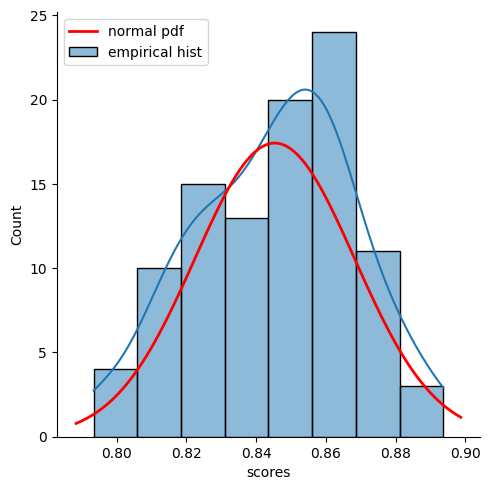

In [22]:
df = pd.DataFrame(data = scores, columns = ['scores'])
print(df.scores.describe())
print(f'Kurtosis \t %s' %round(df.scores.kurtosis(), 5)) 
print(f'Skewness \t %s' %round(df.scores.skew(), 5))
import matplotlib.pyplot as plt
import seaborn as sns
from spicy import stats
ax = sns.displot(data = df.scores, kde = True, label = 'empirical hist')
x0, x1 = ax.ax.get_xlim()
x_pdf = np.linspace(x0, x1, len(df))
y_pdf = stats.norm.pdf(x_pdf, df.scores.mean(), df.scores.std())
ax.ax.plot(x_pdf, y_pdf, 'r', lw = 2, label = 'normal pdf')
ax.ax.legend()

In [23]:
alpha = 1e-3

k2, p = stats.normaltest(df.scores) # Kurtosis and skewness normality test.

if p < alpha :

    print('Kurtosis, Skewness test: The null hypothesis about normality can be rejected.')

else:

    print('Kurtosis, Skewness test: The null hypothesis about normality can not be rejected.')

# Kolmogorov Smirnov normality test.
ks = stats.kstest(df.scores, 'norm')

if ks[1] < alpha :

    print('Kolmogorov Smirnov test: The null hypothesis about normality can be rejected.')

else:

    print('Kolmogorov Smirnov test: The null hypothesis about normality can not be rejected.')

# Do you remember that @kstest function requires NORMALIZATION of sample?
ks = stats.kstest((df.scores - df.scores.mean()) / df.scores.std(), 'norm')

if ks[1] < alpha :

    print('Kolmogorov Smirnov (normalized sample) test: The null hypothesis about normality can be rejected.')

else:

    print('Kolmogorov Smirnov (normalized sample) test: The null hypothesis about normality can not be rejected.')

Kurtosis, Skewness test: The null hypothesis about normality can not be rejected.
Kolmogorov Smirnov test: The null hypothesis about normality can be rejected.
Kolmogorov Smirnov (normalized sample) test: The null hypothesis about normality can not be rejected.


In [24]:
for k in range(1,10):

    X_train, X_test, y_train, y_test = train_test_split(titanic, 
                                                        titanic.survived,
                                                        
                                                        test_size=0.1* k,
                                                        random_state=random.randint(0,1000))
    
    mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = X_train,
    family = sm.families.Binomial())   

    res = mod.fit()
    predsTrain = res.predict(X_train)
    preds = res.predict(X_test)
    print("Train AUC:", round(roc_auc_score(y_train, predsTrain), 4), "Valid AUC:", round(roc_auc_score(y_test, preds), 4))

Train AUC: 0.8522 Valid AUC: 0.8326
Train AUC: 0.8474 Valid AUC: 0.8606
Train AUC: 0.8542 Valid AUC: 0.8389
Train AUC: 0.8503 Valid AUC: 0.8477
Train AUC: 0.85 Valid AUC: 0.8433
Train AUC: 0.8887 Valid AUC: 0.8236
Train AUC: 0.8397 Valid AUC: 0.8439
Train AUC: 0.8673 Valid AUC: 0.8463
Train AUC: 0.8631 Valid AUC: 0.8312


In [25]:
from sklearn.model_selection import KFold

In [27]:
kf = KFold(n_splits = 10, shuffle = True, random_state = random.randint(0, 10000))

for train , test in kf.split(titanic.index.values):

    mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = titanic.iloc[train],
    family = sm.families.Binomial())   

    res = mod.fit()
    predsTrain = res.predict(titanic.iloc[train])
    preds = res.predict(titanic.iloc[test])
    print("Train AUC:", round(roc_auc_score(titanic.iloc[train].survived, predsTrain), 4),
          "Valid AUC:", round(roc_auc_score(titanic.iloc[test].survived, preds), 4))

Train AUC: 0.847 Valid AUC: 0.8853
Train AUC: 0.8492 Valid AUC: 0.8659
Train AUC: 0.848 Valid AUC: 0.8733
Train AUC: 0.8548 Valid AUC: 0.8254
Train AUC: 0.8478 Valid AUC: 0.8825
Train AUC: 0.8508 Valid AUC: 0.8441
Train AUC: 0.8569 Valid AUC: 0.7996
Train AUC: 0.8531 Valid AUC: 0.8146
Train AUC: 0.8524 Valid AUC: 0.8407
Train AUC: 0.85 Valid AUC: 0.8552


In [28]:
for z in range(10) :
    
    trainRes = []
    valRes = []
    kf = KFold(n_splits = 10, shuffle = True, random_state = random.randint(0, 10000))

    for train, test in kf.split(titanic.index.values):

        mod = sm.GLM.from_formula(
        formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
        data = titanic.iloc[train],
        family = sm.families.Binomial())   

        res = mod.fit()
        predsTrain = res.predict(titanic.iloc[train])
        preds = res.predict(titanic.iloc[test])
        trainRes.append(roc_auc_score(titanic.iloc[train].survived,predsTrain))
        valRes.append(roc_auc_score(titanic.iloc[test].survived,preds))

    print("Train AUC:", round(np.mean(trainRes), 4), "Valid AUC:", round(np.mean(valRes), 4))

Train AUC: 0.8511 Valid AUC: 0.8447
Train AUC: 0.8511 Valid AUC: 0.8457
Train AUC: 0.8509 Valid AUC: 0.8481
Train AUC: 0.851 Valid AUC: 0.8493
Train AUC: 0.8511 Valid AUC: 0.8514
Train AUC: 0.851 Valid AUC: 0.8436
Train AUC: 0.851 Valid AUC: 0.8495
Train AUC: 0.851 Valid AUC: 0.8473
Train AUC: 0.8509 Valid AUC: 0.8465
Train AUC: 0.851 Valid AUC: 0.8479


In [29]:
for z in range(10) :
    
    trainRes = []
    valRes = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = random.randint(0, 10000))

    for train, test in kf.split(titanic.index.values):

        mod = sm.GLM.from_formula(
        formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
        data = titanic.iloc[train],
        family = sm.families.Binomial())   

        res = mod.fit()
        predsTrain = res.predict(titanic.iloc[train])
        preds = res.predict(titanic.iloc[test])
        trainRes.append(roc_auc_score(titanic.iloc[train].survived,predsTrain))
        valRes.append(roc_auc_score(titanic.iloc[test].survived,preds))

    print("Train AUC:", round(np.mean(trainRes), 4), "Valid AUC:", round(np.mean(valRes), 4))

Train AUC: 0.8516 Valid AUC: 0.8454
Train AUC: 0.8513 Valid AUC: 0.8447
Train AUC: 0.8518 Valid AUC: 0.8417
Train AUC: 0.8511 Valid AUC: 0.8476
Train AUC: 0.8515 Valid AUC: 0.8461
Train AUC: 0.8513 Valid AUC: 0.8465
Train AUC: 0.8516 Valid AUC: 0.8448
Train AUC: 0.8514 Valid AUC: 0.8436
Train AUC: 0.8513 Valid AUC: 0.8458
Train AUC: 0.851 Valid AUC: 0.8421


In [30]:
predList=[]
indList = []

trainRes = []
valRes = []
kf = KFold(n_splits = 5, shuffle = True, random_state = random.randint(0, 10000))

for train, test in kf.split(titanic.index.values):

    mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = titanic.iloc[train],
    family = sm.families.Binomial())   

    res = mod.fit()
    predsTrain = res.predict(titanic.iloc[train])
    preds = res.predict(titanic.iloc[test])

    predList.append(preds.tolist())
    indList.append(titanic.iloc[test].index.tolist())

    trainRes.append(roc_auc_score(titanic.iloc[train].survived,predsTrain))
    valRes.append(roc_auc_score(titanic.iloc[test].survived,preds))

print("Train AUC:", round(np.mean(trainRes), 4), "Valid AUC:", round(np.mean(valRes), 4))


Train AUC: 0.8514 Valid AUC: 0.8439


In [31]:
predsSorted = pd.Series(sum(predList, []), index = sum(indList, [])).sort_index()
roc_auc_score(titanic.survived.sort_index(), pd.Series(sum(predList, []), index = sum(indList, [])).sort_index())

0.8435579668760709

In [32]:
from sklearn.model_selection import StratifiedKFold

In [34]:
predList=[]
indList = []

trainRes = []
valRes = []
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random.randint(0, 10000))

for train, test in kf.split(titanic.index.values, titanic.survived):

    mod = sm.GLM.from_formula(
    formula = 'survived ~ pclass + sex + age + sibsp + parch + fare + embarked',
    data = titanic.iloc[train],
    family = sm.families.Binomial())   

    res = mod.fit()
    predsTrain = res.predict(titanic.iloc[train])
    preds = res.predict(titanic.iloc[test])

    predList.append(preds.tolist())
    indList.append(titanic.iloc[test].index.tolist())

    trainRes.append(roc_auc_score(titanic.iloc[train].survived,predsTrain))
    valRes.append(roc_auc_score(titanic.iloc[test].survived,preds))

print("Train AUC:", round(np.mean(trainRes), 4), "Valid AUC:", round(np.mean(valRes), 4))


Train AUC: 0.8515 Valid AUC: 0.8437


In [40]:
print(titanic.survived.sum()/titanic.survived.count()*100)

40.74784276126558
